The purpose of this capstone is to accurately predict the quantity of phycocyanin and identify the most important predictors of water quality metrics for making these estimates. In other words, the main goal is to predict the “phycocyanin” column with the explanatory variables and then perform feature importance.

# 1. Data Wrangling

In [2]:
# Libraries imported for this notebook.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from matplotlib.dates import DayLocator
from scipy.interpolate import interp1d
import numpy as np

## Data Acquisition

AquaRealTime provided a login to their data portal from which I downloaded Lake Fictitious data.

In [3]:
# Read Lake_Fictitious_AquaRealTime_Data_Orig into a dataframe, formatted dates, and indexed dates.

df_orig = pd.read_csv('Lake_Fictitious_AquaRealTime_Data_Orig.csv', parse_dates=True, index_col=[1])

In [4]:
# Explored dimensions.

df_orig.shape

(50071, 20)

Confirmed that I should have sufficient rows of data to create regression models.

In [5]:
# Viewed dataframe.

df_orig

,Unnamed: 0,utcTime,light,airTemp,waterTemp,turbidity,phycocyanin,chlorA,waterLight,buoyTemp,battVolts,battSOC,sigStrength,sigQuality,codeVersion,panelVolts,leakDetect,phycocyaninTrend,chlorATrend,turbidityTrend
timeString,,,,,,,,,,,,,,,,,,,,
2021-01-27 11:01:20,NaN,1611774080,483.200012,0.000000,11.5,23.959999,24.43,228.550003,15,17.299999,4.0,96.900002,34.374001,1,2101252,19.5,-1,26.430,248.550,28.792
2021-01-27 11:01:20,NaN,1611774080,483.200012,0.000000,11.5,23.959999,24.43,228.550003,15,17.299999,4.0,96.900002,34.374001,1,2101252,19.5,-1,26.430,248.550,28.792
2021-01-27 11:01:20,NaN,1611774080,483.200012,0.000000,11.5,23.959999,24.43,228.550003,15,17.299999,4.0,96.900002,34.374001,1,2101252,19.5,-1,26.430,248.550,28.792
2021-01-27 11:01:20,NaN,1611774080,483.200012,0.000000,11.5,23.959999,24.43,228.550003,15,17.299999,4.0,96.900002,34.374001,1,2101252,19.5,-1,26.430,248.550,28.792
2021-01-27 11:01:20,NaN,1611774080,483.200012,0.000000,11.5,23.959999,24.43,228.550003,15,17.299999,4.0,96.900002,34.374001,1,2101252,19.5,-1,26.430,248.550,28.792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23 05:30:40,NaN,1708695040,0.000000,8.510274,15.0,2.210000,8.51,96.839996,29,14.500000,3.9,81.300003,54.999619,67,230209,0.1,25,10.422,97.973,4.597
2024-02-23 06:00:32,NaN,1708696832,0.000000,8.510274,14.9,2.400000,8.51,93.339996,29,14.100000,3.9,81.099998,54.999619,67,230209,0.2,27,10.403,97.741,4.575
2024-02-23 06:30:24,NaN,1708698624,5.200000,9.726027,14.8,2.210000,9.72,94.510002,29,13.900000,3.9,80.900002,54.999619,67,230209,4.8,32,10.396,97.580,4.551


Data looks in very good condition. Little cleaning to be done. I can see right away that I have an empty column and some duplicate rows.

## Data Cleaning

### Columns

In [6]:
# Removed unneeded columns.

df = df_orig[['light', 'waterTemp', 'turbidity', 'phycocyanin', 'chlorA']].copy()

In [7]:
# Rounded times to the nearest half hour so I have simpler times to work with.

df.index = df.index.round('30min')

### Duplicate Rows

In [8]:
# Checked for duplicate rows

duplicate_rows = df.index.duplicated(keep=False)
df[duplicate_rows]

,light,waterTemp,turbidity,phycocyanin,chlorA
timeString,,,,,
2021-01-27 11:00:00,483.200012,11.500000,23.959999,24.430000,228.550003
2021-01-27 11:00:00,483.200012,11.500000,23.959999,24.430000,228.550003
2021-01-27 11:00:00,483.200012,11.500000,23.959999,24.430000,228.550003
2021-01-27 11:00:00,483.200012,11.500000,23.959999,24.430000,228.550003
2021-01-27 11:00:00,483.200012,11.500000,23.959999,24.430000,228.550003
...,...,...,...,...,...
2023-10-02 08:00:00,321.299988,20.700001,10.080000,58.349998,168.020004
2023-11-05 01:00:00,0.000000,16.400000,7.520000,38.900002,415.399994
2023-11-05 01:30:00,0.000000,16.299999,8.110000,38.900002,418.899994


Many duplicate datetimes. Need to fix this. I don't want to just delete the second occurance becasue I sometimes have slightly different data for the same datetimes. Taking the average is more appropriate.

In [9]:
# Removed duplicates by takeing mean of values with the same date and time.

df = df.groupby(df.index).mean()

In [10]:
# Confirmed no duplicate rows.

duplicate_rows = df.index.duplicated(keep=False)
df[duplicate_rows]

,light,waterTemp,turbidity,phycocyanin,chlorA
timeString,,,,,


In [11]:
# Confirmed changes.

df

,light,waterTemp,turbidity,phycocyanin,chlorA
timeString,,,,,
2021-01-27 11:00:00,483.200012,11.5,23.959999,24.430000,228.550003
2021-01-27 12:00:00,603.599976,12.0,22.770000,22.549999,213.500000
2021-01-27 13:00:00,455.600006,12.7,23.070000,25.370001,245.889999
2021-01-27 14:00:00,407.399994,12.6,22.620001,26.309999,251.360001
2021-01-27 15:00:00,308.299988,13.0,21.740000,31.010000,331.660004
...,...,...,...,...,...
2024-02-23 05:30:00,0.000000,15.0,2.210000,8.510000,96.839996
2024-02-23 06:00:00,0.000000,14.9,2.400000,8.510000,93.339996
2024-02-23 06:30:00,5.200000,14.8,2.210000,9.720000,94.510002


### Missing data

In [12]:
# Explored data.

index_dtype = df.index.dtype
print("Index Data Type:", index_dtype)
print()
df.info()

Index Data Type: datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49823 entries, 2021-01-27 11:00:00 to 2024-02-23 07:30:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   light        49823 non-null  float64
 1   waterTemp    49823 non-null  float64
 2   turbidity    49823 non-null  float64
 3   phycocyanin  49823 non-null  float64
 4   chlorA       49823 non-null  float64
dtypes: float64(5)
memory usage: 3.3 MB


No missing data and all data is in the correct dtype. Although, this does not identify rows that are missing entirely.

In [13]:
# Checked for missing rows.

# Calulated difference in time between rows
time_diff = df.index.to_series().diff()

# Converted nanoseconds to half hours
time_diff_hours = time_diff / (1.8 * 10**12)

# Printed all the unique values of the calculated time difference
time_diff_hours = time_diff_hours[1:] # Exclude the first row becasue a difference cannot be calculates.
print("Data gaps with number of missing rows:")
print(time_diff_hours.unique())

Data gaps with number of missing rows:
[  2 148  34   4   1   3  18   9 296   5   6  11  17  57]


The data has gaps in which the unit must not have been on. The largest gap is 6.25 days which is not too large to impute.

In [14]:
# Inserted rows where they shoud be in the dataframe.

# Found location of missing rows
expected_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='30T')
missing_index = expected_index.difference(df.index)

# Inserted missing rows with NaN values
for missing_date in missing_index:
    df.loc[missing_date] = pd.Series(dtype=float)

# Sorted the dataframe by index
df = df.sort_index()

In [15]:
# Confirmed addition of rows.

df

,light,waterTemp,turbidity,phycocyanin,chlorA
timeString,,,,,
2021-01-27 11:00:00,483.200012,11.5,23.959999,24.430000,228.550003
2021-01-27 11:30:00,NaN,NaN,NaN,NaN,NaN
2021-01-27 12:00:00,603.599976,12.0,22.770000,22.549999,213.500000
2021-01-27 12:30:00,NaN,NaN,NaN,NaN,NaN
2021-01-27 13:00:00,455.600006,12.7,23.070000,25.370001,245.889999
...,...,...,...,...,...
2024-02-23 05:30:00,0.000000,15.0,2.210000,8.510000,96.839996
2024-02-23 06:00:00,0.000000,14.9,2.400000,8.510000,93.339996
2024-02-23 06:30:00,5.200000,14.8,2.210000,9.720000,94.510002


I will fill these NaNs later.

In [16]:
# Rechecked for missing rows.

# Calulated difference in time between rows
time_diff = df.index.to_series().diff()

# Convert nanoseconds to half hours
time_diff_hours = time_diff / (1.8 * 10**12)

# Exclude the first row because a difference cannot be calculated.
time_diff_hours = time_diff_hours[1:]

# Count occurrences of each unique value
unique_counts = time_diff_hours.value_counts()

# Print unique values and their counts
print("Number of missing rows in data gaps and count:")
for value, count in unique_counts.items():
    print(f"{value}: {count}")

Number of missing rows in data gaps and count:
0 days 00:00:00.000000001: 53849


No missing rows.

### Values

In [17]:
# Printed summary statistics.

df.describe()

,light,waterTemp,turbidity,phycocyanin,chlorA
count,49823.000000,49823.000000,49823.000000,49823.000000,49823.000000
mean,165.370635,18.731209,62.485628,116.725729,635.287967
std,247.221653,6.328209,100.671570,172.555341,703.107594
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,13.700000,4.870000,9.860000,98.010002
50%,0.300000,18.000000,16.530001,54.700001,307.619995
75%,292.650009,24.299999,75.019997,164.979996,921.090027
max,2442.000000,43.400002,400.000000,1654.640015,3000.000000


Observations from these descriptions:  
light - All values are possible.    
waterTemp - A min of zero is possabe as long as it occurs in winter months. A max of 43 is unlikely. I will check this when I plot the data.  
turbidity - All values are possible. A max of 400 is unlikely. I will check this when I plot the data.  
phycocyanin - All values are possible. A max of 1655 is unlikely. I will check this when I plot the data.  
chlorA - All values are possible. A max of 3000 is unlikely. I will check this when I plot the data.

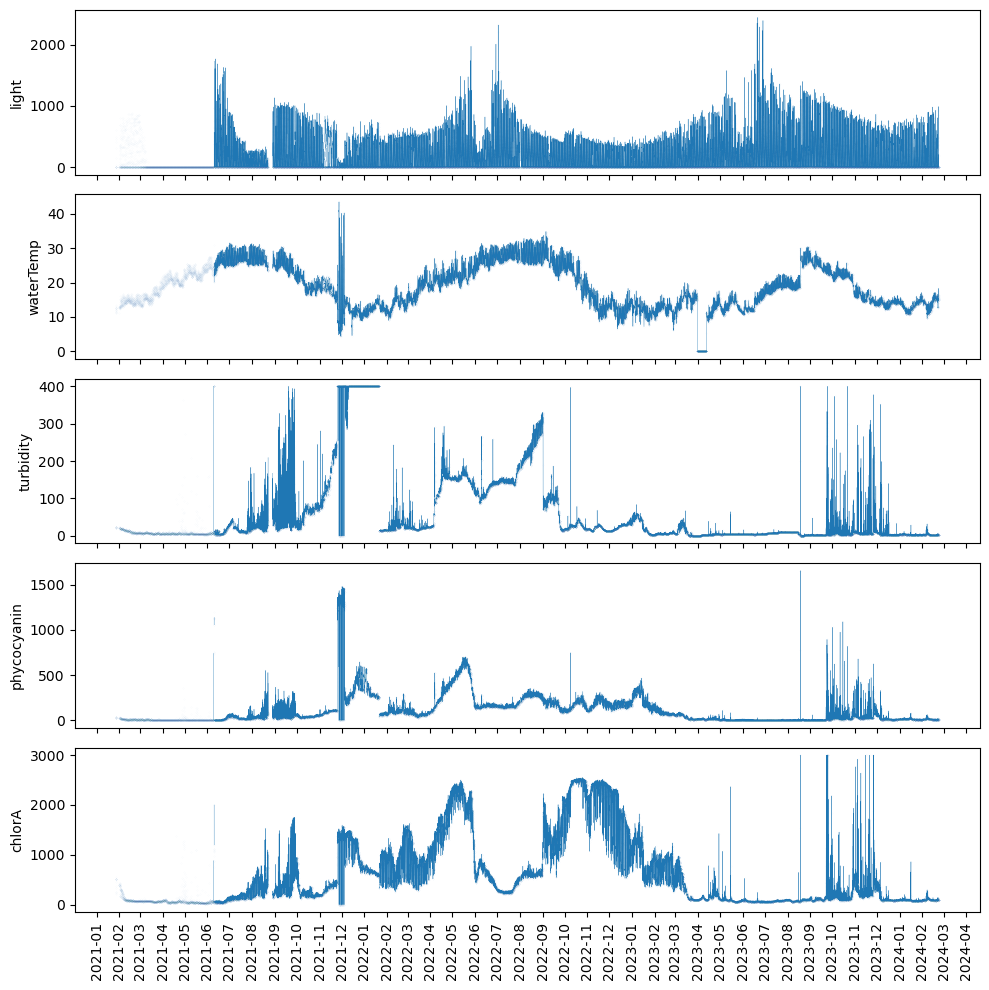

In [18]:
# Plotted data.

fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 2 * len(df.columns)), sharex=True)
for i, column in enumerate(df.columns):
    axes[i].plot(df.index, df[column], marker='o', markersize=0.01, linestyle='-', linewidth=0.25)
    axes[i].set_ylabel(column)
    axes[i].xaxis.set_major_locator(MonthLocator())
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Observations from these plots:    
light - Small portion of data is too low. The sensor may have been covered with debris.  
waterTemp - Some sensor errors caused by likely a faulty sensor.  
turbidity - Some sensor errors caused by likely a faulty sensor.  
phycocyanin - Some sensor errors caused by likely a faulty sensor.  
chlorA - Some sensor errors caused by likely a faulty sensor.

Missing values will be interpolated using spline linear interpolation. This interpolation tries to ensure smoothness and continuity in the interpolated curve.

In [19]:
# Defined function to interpolate NaN values using linear spline interpolation.

def interpolate_nan_with_spline(series):
    nan_indices = series.index[series.isna()]
    non_nan_indices = series.index[~series.isna()]
    
    # Create interpolation function
    interpolation_func = interp1d(non_nan_indices, series.dropna(), kind='slinear', fill_value='extrapolate')
    
    # Interpolate NaN values
    series[nan_indices] = interpolation_func(nan_indices)
    
    return series

#### Light Metric

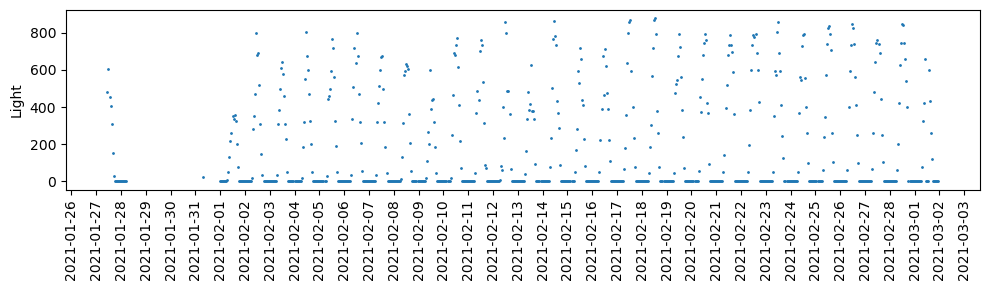

In [20]:
# Zoomed in on low values.

# Filter the DataFrame for the desired date range
filtered_df = df.loc['2021-01-01':'2021-03-01', ['light']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['light'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('Light')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Looks like the sensor was down from 1/28/21 to 1/31/21.

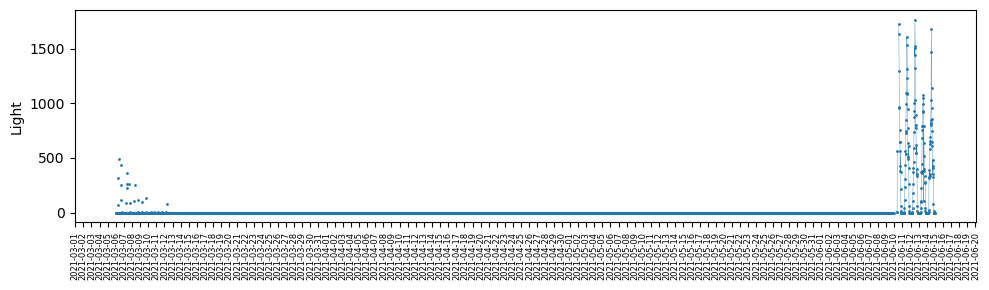

In [21]:
# Zoomed in on low values.

# Filter the DataFrame for the desired date range
filtered_df = df.loc['2021-03-06':'2021-06-14', ['light']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['light'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('Light')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90, labelsize=6)
plt.tight_layout()
plt.show()

Looks like the sensor was recording unrealistically low values from 3/10/21 to 6/10/21.

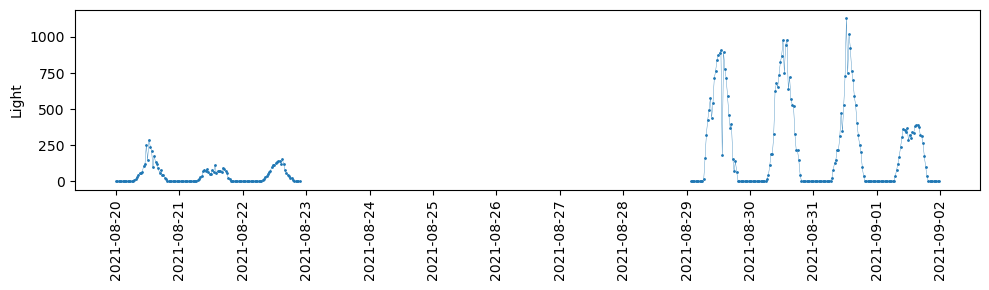

In [22]:
# Zoomed in on low values.

# Filter the DataFrame for the desired date range
filtered_df = df.loc['2021-08-20':'2021-09-01', ['light']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['light'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('Light')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

And down from 8/23/21 to 8/29/21.

I will replace these NaNs and low values with the mean values of the corresponding dates in 2022 and 2023. Linear interpolation would not be appropriate for these big gaps because light is at zero every night and a straight line would not capture this day/night complexity. However, interpolation is fine for small gaps because there is less complexity. 

In [23]:
# Replaced missing and unrealistic low 'light' values with the mean of corresponding days from 2022 and 2023.

# Created a mask for the specified time ranges
mask = (
    (df.index >= '2021-01-28 00:00:00') & (df.index <= '2021-01-31 23:30:00') |
    (df.index >= '2021-03-10 00:00:00') & (df.index <= '2021-06-10 23:30:00') |
    (df.index >= '2021-08-23 00:00:00') & (df.index <= '2021-08-29 23:30:00')
)

# Iterate over each datetime in the specified time ranges
for index, row in df[mask].iterrows():
    # Extract the day, month, and time
    day = index.day
    month = index.month
    time = index.time()
    
    # Filter the dataframe to get the rows with the same day, month, and time, excluding the rows from the mask
    same_day_month_time = df[(df.index.day == day) & (df.index.month == month) & (df.index.time == time) & (~mask)]
    
    # Calculate the average of light values for the same day, month, and time
    avg_light = same_day_month_time['light'].mean()
    
    # Replace the value in the specified time range with the average
    df.loc[index, 'light'] = avg_light

In [24]:
# Applied interpolation function to 'light' column.

df['light'] = interpolate_nan_with_spline(df['light'])

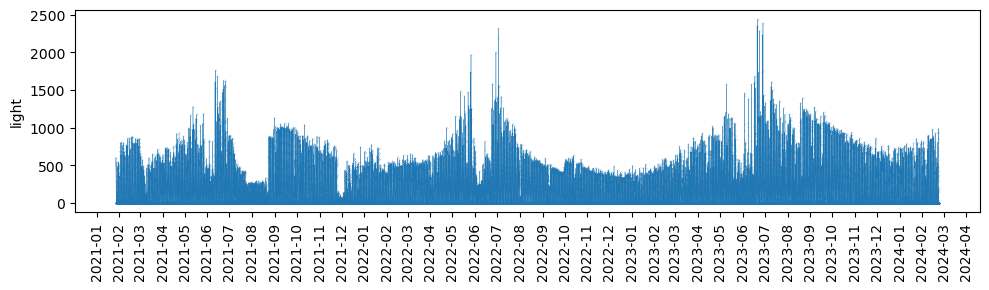

In [25]:
# Replotted metric to see filled data.

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df.index, df['light'], marker='o', markersize=.1, linestyle='-', linewidth=0.25)
ax.set_ylabel('light')
ax.xaxis.set_major_locator(MonthLocator())
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Water Temp Metric

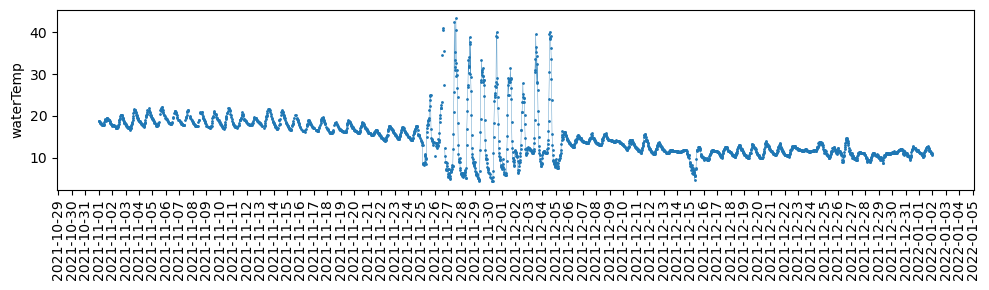

In [26]:
# Zoomed in on irratic values.

# Filtered the DataFrame for the desired date range
filtered_df = df.loc['2021-11-01':'2022-01-01', ['waterTemp']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['waterTemp'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('waterTemp')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

##### Looks like a sensor issue from 11/25/21 to 12/06/21.

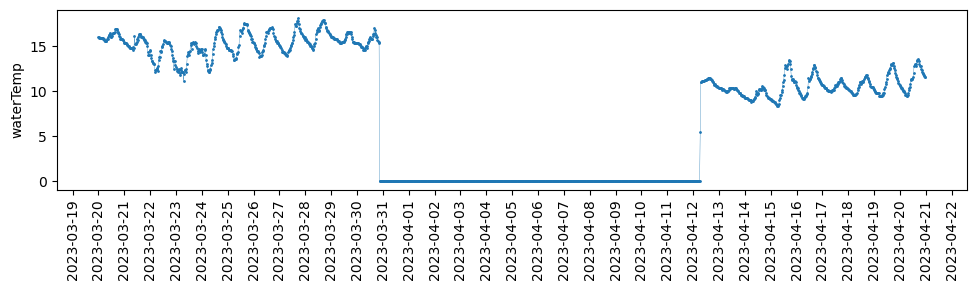

In [27]:
# Zoomed in on low values.

# Filtered the DataFrame for the desired date range
filtered_df = df.loc['2023-03-20':'2023-04-20', ['waterTemp']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['waterTemp'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('waterTemp')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

And from 03/30/23 to 04/13/23.

In [28]:
# Removed 'waterTemp' data that is extreme and does not follow the pattern of surrounding data.

# Defined date ranges with inaccurate readings
faulty_periods = [
    ('2021-11-25', '2021-12-06'),
    ('2023-03-30', '2023-04-13')
]

# Converted to datetime objects
faulty_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in faulty_periods]

# Replaced values with NaN for the specified date ranges
for start, end in faulty_periods:
    df.loc[start:end, 'waterTemp'] = float('nan')

In [29]:
# Applied interpolation function to 'waterTemp' column.

df['waterTemp'] = interpolate_nan_with_spline(df['waterTemp'])

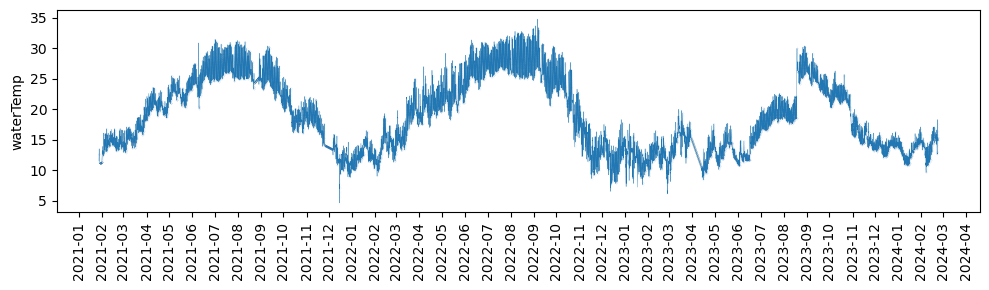

In [30]:
# Replotted metric to see filled data.

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df.index, df['waterTemp'], marker='o', markersize=0.01, linestyle='-', linewidth=0.25)
ax.set_ylabel('waterTemp')
ax.xaxis.set_major_locator(MonthLocator())
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Turbidity Metric

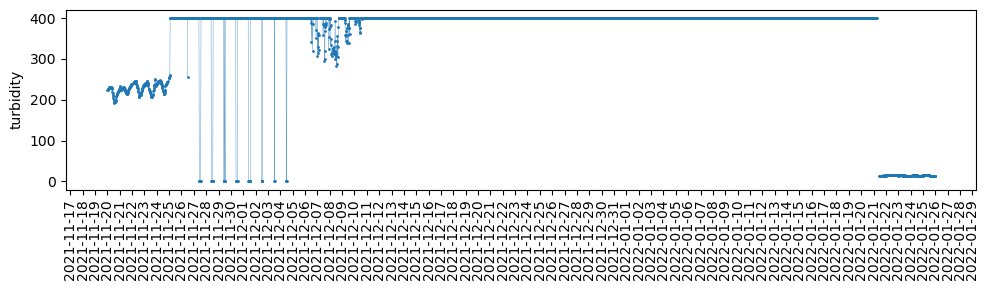

In [31]:
# Zoomed in on irratic values.

# Filtered the DataFrame for the desired date range
filtered_df = df.loc['2021-11-20':'2022-01-25', ['turbidity']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['turbidity'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('turbidity')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Looks like the sensor was down from 11/25/21 to 01/22/22.

In [32]:
# Removed 'turbidity' data that is extreme and does not follow the pattern of surrounding data.

# Definde date ranges with inaccurate readings
faulty_periods = [
    ('2021-11-25', '2022-01-22')
]

# Converted to datetime objects
faulty_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in faulty_periods]

# Replaced values with NaN for the specified date ranges
for start, end in faulty_periods:
    df.loc[start:end, 'turbidity'] = float('nan')

In [33]:
# Replaced 400 and above with NaN in the 'turbidity' column.

df.loc[df['turbidity'] >= 400, 'turbidity'] = np.nan

In [34]:
# Applied interpolation function to 'turbidity' column.

df['turbidity'] = interpolate_nan_with_spline(df['turbidity'])

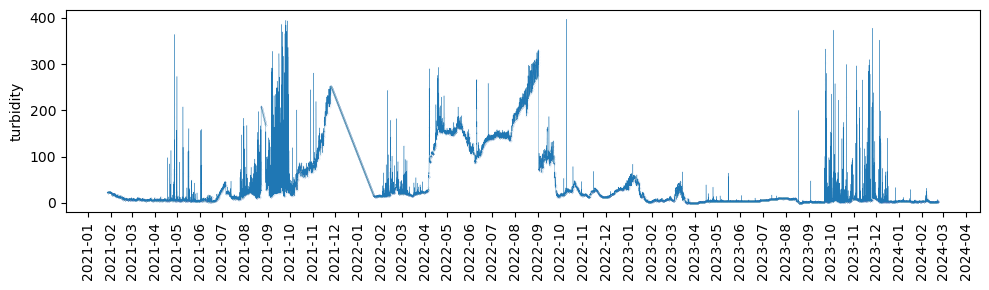

In [35]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df.index, df['turbidity'], marker='o', markersize=0.01, linestyle='-', linewidth=0.25)
ax.set_ylabel('turbidity')
ax.xaxis.set_major_locator(MonthLocator())
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Phycocyanin Metric

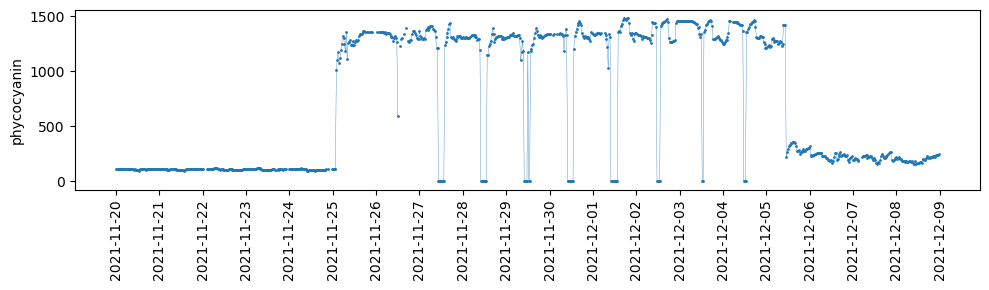

In [36]:
# Zoomed in on irratic values.

# Filtered the DataFrame for the desired date range
filtered_df = df.loc['2021-11-20':'2021-12-08', ['phycocyanin']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['phycocyanin'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('phycocyanin')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Looks like the sensor was down from 11/25/21 to 12/06/21.

In [37]:
# Removed 'phycocyanin' data that is extreme and does not follow the pattern of surrounding data.

# Defined date ranges with inaccurate readings
faulty_periods = [
    ('2021-11-25', '2021-12-06')
]

# Converted to datetime objects
faulty_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in faulty_periods]

# Replaced values with NaN for the specified date ranges
for start, end in faulty_periods:
    df.loc[start:end, 'phycocyanin'] = float('nan')

In [38]:
# Replaced 1500 and above with NaN in the 'phycocyanin' column.

df.loc[df['phycocyanin'] >= 1500, 'phycocyanin'] = np.nan

In [39]:
# Applied interpolation function to 'phycocyanin' column.

df['phycocyanin'] = interpolate_nan_with_spline(df['phycocyanin'])

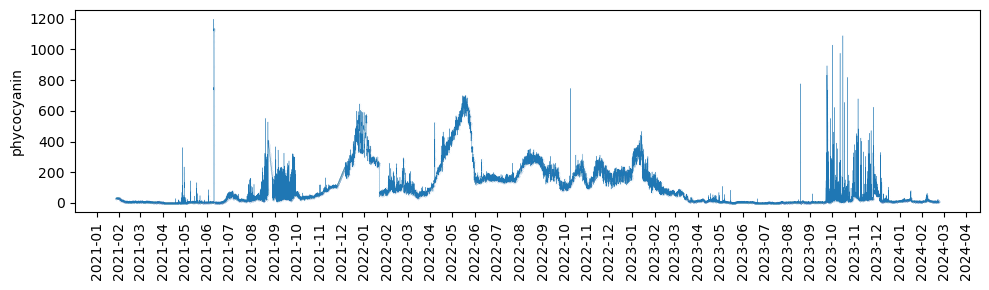

In [40]:
# Replotted metric to see filled data.

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df.index, df['phycocyanin'], marker='o', markersize=0.01, linestyle='-', linewidth=0.25)
ax.set_ylabel('phycocyanin')
ax.xaxis.set_major_locator(MonthLocator())
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Chlorophyll-a Metric

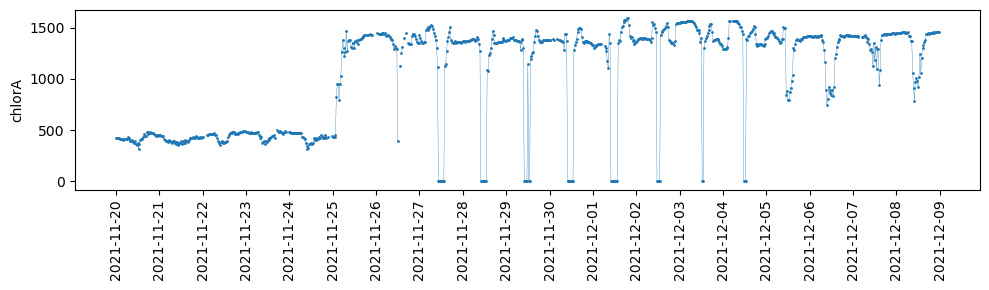

In [41]:
# Zoomed in on irratic values.

# Filtered the DataFrame for the desired date range
filtered_df = df.loc['2021-11-20':'2021-12-08', ['chlorA']]

# Plotted
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3), sharex=True)
axes.plot(filtered_df.index, filtered_df['chlorA'], marker='o', markersize=1, linestyle='-', linewidth=0.25)
axes.set_ylabel('chlorA')
axes.xaxis.set_major_locator(DayLocator())
axes.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

Looks like the sensor was down from 11/25/21 to 12/05/21.

In [42]:
# Removed 'chlorA' data that is extreme and does not follow the pattern of surrounding data.

# Defined date ranges with inaccurate readings
faulty_periods = [
    ('2021-11-25', '2021-12-05')
]

# Converted to datetime objects
faulty_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in faulty_periods]

# Replaced values with NaN for the specified date ranges
for start, end in faulty_periods:
    df.loc[start:end, 'chlorA'] = float('nan')

In [43]:
# Replaced 3000 and above with NaN in the 'chlorA' column.

df.loc[df['chlorA'] >= 3000, 'chlorA'] = np.nan

In [44]:
# Applied interpolation function to 'chlorA' column.

df['chlorA'] = interpolate_nan_with_spline(df['chlorA'])

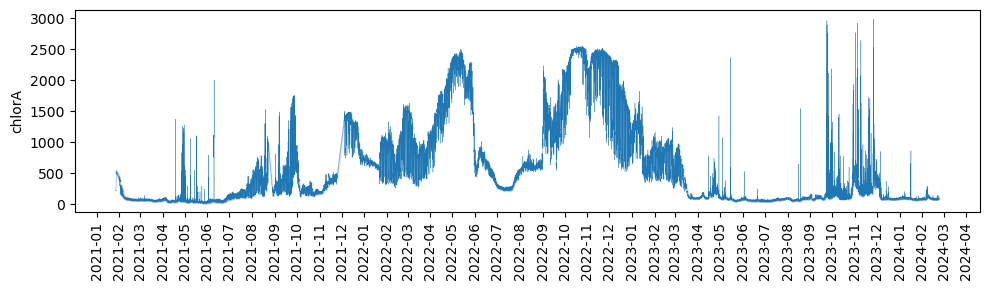

In [45]:
# Replotted metric to see filled data.

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df.index, df['chlorA'], marker='o', markersize=0.01, linestyle='-', linewidth=0.25)
ax.set_ylabel('chlorA')
ax.xaxis.set_major_locator(MonthLocator())
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [46]:
# Explored data to confirm all NaNs were filled.

index_dtype = df.index.dtype
print("Index Data Type:", index_dtype)
print()
df.info()

Index Data Type: datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53850 entries, 2021-01-27 11:00:00 to 2024-02-23 07:30:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   light        53850 non-null  float64
 1   waterTemp    53850 non-null  float64
 2   turbidity    53850 non-null  float64
 3   phycocyanin  53850 non-null  float64
 4   chlorA       53850 non-null  float64
dtypes: float64(5)
memory usage: 4.5 MB


# Data Save

In [47]:
# Saved dataframe.

df.to_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned.xlsx', index=True)